In [25]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import datetime

In [26]:
start = pd.to_datetime('2007-02-04')
end = pd.to_datetime('2020-11-23')

In [27]:
df = data.DataReader('SPY', 'yahoo', start, end)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-02-05,144.940002,144.339996,144.699997,144.850006,45705300.0,109.564392
2007-02-06,145.029999,144.330002,144.970001,144.889999,57081300.0,109.594658
2007-02-07,145.360001,144.570007,145.119995,145.210007,55669700.0,109.836716
2007-02-08,145.119995,144.270004,144.779999,145.020004,70641000.0,109.692993
2007-02-09,145.330002,143.389999,145.059998,143.940002,79084400.0,108.876068
...,...,...,...,...,...,...
2020-11-17,361.920013,358.339996,359.970001,360.619995,66111000.0,360.619995
2020-11-18,361.500000,356.239990,360.910004,356.279999,70591300.0,356.279999
2020-11-19,358.179993,354.149994,355.600006,357.779999,59940900.0,357.779999


In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
input_vars = ['Open', 'High', 'Low', 'Close', 'Volume']

n_tsteps = 15
scaler = StandardScaler()

# used to classify future stock price movement
class Direction:
    UP = 0
    DOWN = 1
    STATIONARY = 2

In [30]:
import math
def prep_data(data, rolling_avg_window_size=5, stationary_threshold=.0001):
    # rolling_avg_window_size = window size for the future mid prices to average, 
    #   this average is what the model wants to predict
    # stationary_threshold = maximum change of movement to be considered stationary 
    #   for the average mid price stated above 

    df = data[input_vars]
    shift = -(rolling_avg_window_size-1)

    def label_data(row):
        if row['close_avg_change_pct'] > stationary_threshold:
            return Direction.UP
        elif row['close_avg_change_pct'] < -stationary_threshold:
            return Direction.DOWN
        else:
            return Direction.STATIONARY

    df['close_avg'] = df['Close'].rolling(window=rolling_avg_window_size).mean().shift(shift) 
    df['close_avg_change_pct'] = (df['close_avg'] - df['Close']) / df['Close']

    # label data based on direction
    # axis=1 signifies a row-wise operation (axis=0 is col-wise)
    df['movement_labels'] = df.apply(label_data, axis=1)

    data = []
    labels = []

    for i in range(len(df)-n_tsteps+1+shift):
        label = df['movement_labels'].iloc[i+n_tsteps-1]
        if not math.isnan(label):
            data.append(df[input_vars].iloc[i:i+n_tsteps].values)
            labels.append(label)

    data = np.array(data)
    dim1, dim2, dim3 = data.shape
    data = data.reshape(dim1*dim2, dim3)
    data = scaler.fit_transform(data)
    data = data.reshape(dim1, dim2, dim3)

    return data, utils.to_categorical(labels, num_classes=3)
labels = [1,1,0]
# utils.to_categorical(labels, num_classes=3)

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Lambda, Flatten, Concatenate
from tensorflow.keras import Model
from tensorflow.keras import metrics
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import utils

def build_model():
    inputs = Input(shape=(n_tsteps, len(input_vars)))
    feature_extraction = Conv1D(30, 4, activation='relu')(inputs)
    long_term = Lambda( lambda x: tf.split(x, num_or_size_splits=3, axis=1)[0])(feature_extraction)
    mid_term = Lambda( lambda x: tf.split(x, num_or_size_splits=3, axis=1)[1])(feature_extraction)
    short_term = Lambda( lambda x: tf.split(x, num_or_size_splits=3, axis=1)[2])(feature_extraction)    
    long_term_conv = Conv1D(1, 1, activation='relu')(long_term)
    mid_term_conv = Conv1D(1, 1, activation='relu')(mid_term)
    short_term_conv = Conv1D(1, 1, activation='relu')(short_term)
    combined = Concatenate(axis=1)([long_term_conv, mid_term_conv, short_term_conv])
    flattened = Flatten()(combined)
    # 1 output neuron for each class (Up, Stationary, Down)
    outputs = Dense(3, activation='softmax')(flattened)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss=CategoricalCrossentropy(from_logits=True))
    return model

In [32]:
data1, labels1 = prep_data(df)

In [40]:
model = build_model()
model.fit(data1, labels1, validation_split=.2, epochs=20)

Epoch 1/20
87/87 [==============================] - 0s 2ms/step - loss: 1.0322 - val_loss: 0.9957
Epoch 2/20
87/87 [==============================] - 0s 1ms/step - loss: 0.9705 - val_loss: 0.9456
Epoch 3/20
87/87 [==============================] - 0s 1ms/step - loss: 0.9562 - val_loss: 0.9352
Epoch 4/20
87/87 [==============================] - 0s 1ms/step - loss: 0.9528 - val_loss: 0.9352
Epoch 5/20
87/87 [==============================] - 0s 1ms/step - loss: 0.9508 - val_loss: 0.9360
Epoch 6/20
87/87 [==============================] - 0s 1ms/step - loss: 0.9487 - val_loss: 0.9363
Epoch 7/20
87/87 [==============================] - 0s 1ms/step - loss: 0.9481 - val_loss: 0.9373
Epoch 8/20
87/87 [==============================] - 0s 1ms/step - loss: 0.9481 - val_loss: 0.9367
Epoch 9/20
87/87 [==============================] - 0s 997us/step - loss: 0.9478 - val_loss: 0.9388
Epoch 10/20
87/87 [==============================] - 0s 1ms/step - loss: 0.9483 - val_loss: 0.9381
Epoch 11/20
87/87

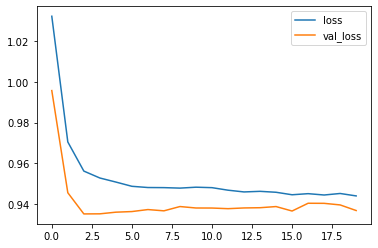

In [41]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [35]:
output = model.predict(data1[0][np.newaxis, :])[0]

In [36]:
direction = np.argmax(output)
confidence = output[direction]

In [37]:
output

array([3.3005130e-01, 6.6994870e-01, 2.5901645e-08], dtype=float32)

In [38]:
direction

1

In [39]:
confidence

0.6699487